<a href="https://colab.research.google.com/github/THANNAGA/DynamicLearner/blob/main/DynamicLearnerSpoke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn dynamically on word spectrograms

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import gc, os, time

Data

In [ ]:
shared_path = "/content/drive/MyDrive/deep-pc/dpc-models/models_with_threshold/"
dataset= 'Earshot'
train_speakers = ['Alex','Allison','Ava','Bruce','Fred','Junior','Kathy','Princess','Ralph','Samantha']
test_speakers = ['Agnes']
archi = "tf_ia"#"tf_pc"#"tf_ia"#"tf_state"#"tf_fullstate"#"tf_state"
save_model = False
load_model = False

input_size = 50  #frequencies in spectrogram input
input_time_steps = 112 #times in spectrogram input
k = 1 #move the input window every k steps
window_size = 50  #how big a chunk of the spectrogram should we process every k steps
stride = 1 #how the window should overlap as it moves
n_iter = 50 # how many steps of processing (everything but the input is updated at each step)

n_classes = 150
select_word_classes = True
state_size = 1024
hidden_size = 1024
h_step = 0.1 #between 0 and 1

epochs = 300
batchsize = 90
n_workers = 1
nesterov = True

d_model = 128
n_blocks = 2
n_heads = 2


"""
#parameters that work:
shared_path = "/content/drive/MyDrive/deep-pc/dpc-models/models_with_threshold/"
dataset= 'Earshot'
train_speakers = ['Alex','Allison','Ava','Bruce','Fred','Junior','Kathy','Princess','Ralph','Samantha']
test_speakers = ['Agnes']
archi = "tf_ia"#"tf_state"#"tf_fullstate"#"tf_state"

input_size = 50  #freq bands in spectrogram inputs
input_time_steps = 112 #number of time steps in spectrogram input
window_size = 30  #how big a chunk of the spectrogram should we process at the same time
k = 5
n_iter = 50

n_classes = 70
select_word_classes = True
state_size = 1024
hidden_size = 512
h_step = 0.1 #between 0 and 1

epochs = 200
batchsize = 90
n_workers = 2
nesterov = False

d_model = 128
n_blocks = 2
n_heads = 8
"""

'\n#parameters that work:\nshared_path = "/content/drive/MyDrive/deep-pc/dpc-models/models_with_threshold/"\ndataset= \'Earshot\'\ntrain_speakers = [\'Alex\',\'Allison\',\'Ava\',\'Bruce\',\'Fred\',\'Junior\',\'Kathy\',\'Princess\',\'Ralph\',\'Samantha\']\ntest_speakers = [\'Agnes\']\narchi = "tf_ia"#"tf_state"#"tf_fullstate"#"tf_state"\n\ninput_size = 50  #freq bands in spectrogram inputs\ninput_time_steps = 112 #number of time steps in spectrogram input\nwindow_size = 30  #how big a chunk of the spectrogram should we process at the same time\nk = 5\nn_iter = 50\n\nn_classes = 70\nselect_word_classes = True\nstate_size = 1024\nhidden_size = 512\nh_step = 0.1 #between 0 and 1\n\nepochs = 200\nbatchsize = 90\nn_workers = 2\nnesterov = False\n\nd_model = 128\nn_blocks = 2\nn_heads = 8\n'

In [ ]:

  class EarshotDataset2(Dataset):
    def __init__(self, X, Y, w, s, transform=None):
      self.X = X
      self.Y = Y
      self.w = w
      self.s = s
      self.transform = transform

    def __len__(self):
      return len(self.Y)

    def __getitem__(self, index):
      if self.transform:
        sample = self.transform(self.X[index])
        x = torch.tensor(sample).float()
      else:
        x = torch.tensor(self.X[index]).float()
      y = torch.tensor(self.Y[index]).float()

      return (x, y, self.w[index], self.s[index])

In [ ]:
# Load dataset for one speaker
trainset = torch.load(shared_path+'model_n1000_x'+test_speakers[-1]+'/trainset_x'+test_speakers[-1]+'.pth')
testset_w = torch.load(shared_path+'model_n1000_x'+test_speakers[-1]+'/testset_w_x'+test_speakers[-1]+'.pth')
testset_s = torch.load(shared_path+'model_n1000_x'+test_speakers[-1]+'/testset_s_x'+test_speakers[-1]+'.pth')


# Maybe select
if select_word_classes:

  def select_word_classes(dataset, start_label=0, end_label=99):
    """Selects word classes within a specified range from a dataset."""
    mask = [start_label <= label <= end_label for label in dataset.Y]
    X_selected = [x for x, m in zip(dataset.X, mask) if m]
    Y_selected = [y for y, m in zip(dataset.Y, mask) if m]
    w_selected = [w for w, m in zip(dataset.w, mask) if m]
    s_selected = [s for s, m in zip(dataset.s, mask) if m]
    return EarshotDataset2(X_selected, Y_selected, w_selected, s_selected)

  # Select word classes 0 to 99 from each dataset
  trainset = select_word_classes(trainset, start_label=0, end_label=n_classes-1)
  testset_w = select_word_classes(testset_w, start_label=0, end_label=n_classes-1)
  testset_s = select_word_classes(testset_s, start_label=0, end_label=n_classes-1)


<ipython-input-163-5f926b12fef9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainset = torch.load(shared_path+'model_n1000_x'+test_speakers[-1]+'/trainset_x'+test_spea

In [ ]:
# Build the train and test loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=n_workers)
testloader_w = torch.utils.data.DataLoader(testset_w, batch_size=n_classes, shuffle=False, num_workers=n_workers)
testloader_s = torch.utils.data.DataLoader(testset_s, batch_size=n_classes, shuffle=False, num_workers=n_workers)

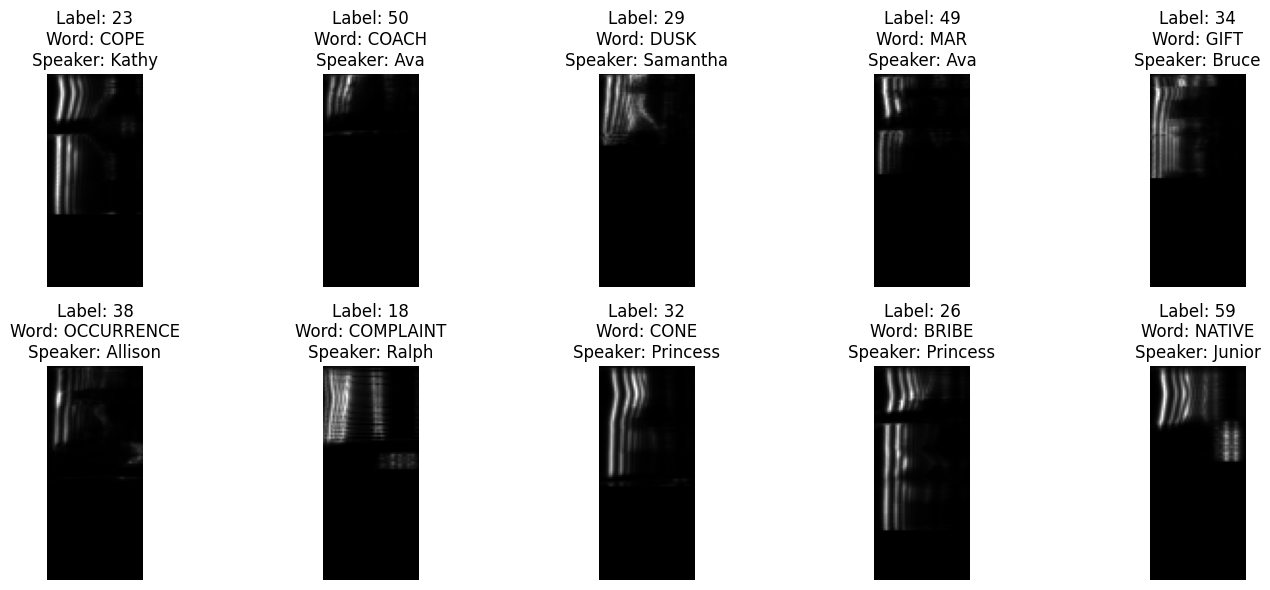

Total samples: 630
Batch size: 90
Sample shape: torch.Size([112, 50])
Label shape: torch.Size([90])
Word length: 90
Speaker shape: 90


In [ ]:
# Get a batch of data from the trainloader
dataiter = iter(trainloader)
images, labels, words, speakers = next(dataiter)

# Display the first 10 images with word and speaker information
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Increased figsize for better readability
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(f'Label: {int(labels[i])}\nWord: {words[i]}\nSpeaker: {speakers[i]}')  # Added word and speaker
    ax.axis('off')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Print dataloader structure
print(f"Total samples: {len(trainset)}")
print(f"Batch size: {trainloader.batch_size}")
print(f"Sample shape: {images[0].shape}")
print(f"Label shape: {labels.shape}")
print(f"Word length: {len(words)}")
print(f"Speaker shape: {len(speakers)}")

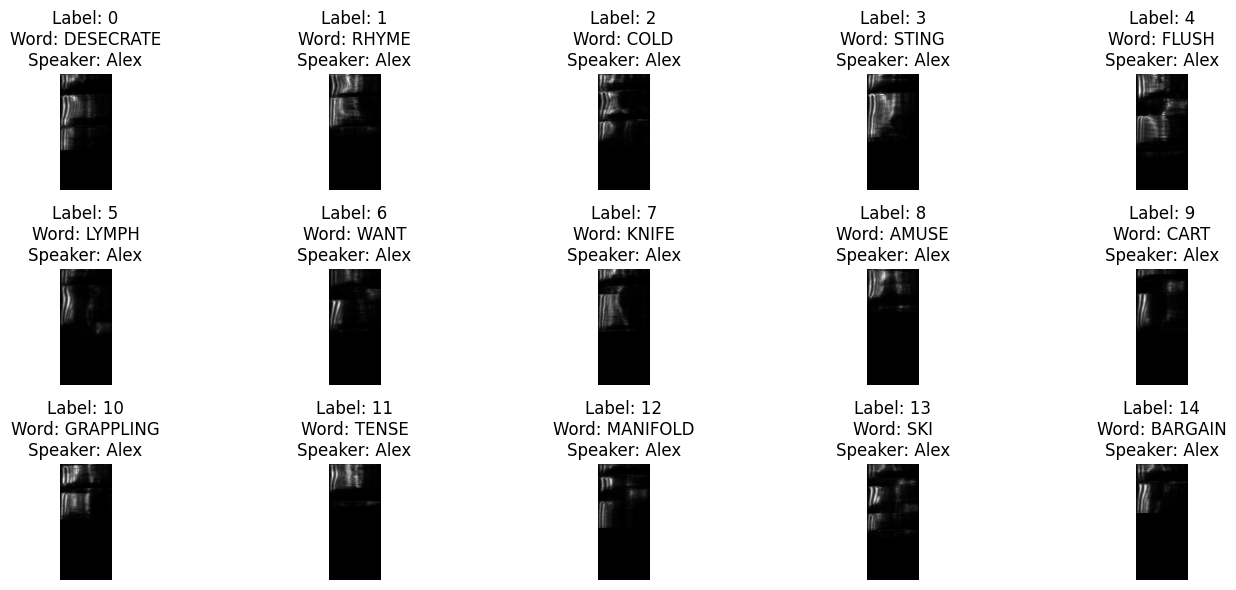

Total samples: 630
Batch size: 90
Sample shape: torch.Size([112, 50])
Label shape: torch.Size([70])
Word length: 70
Speaker shape: 70


In [ ]:
# Get a batch of data from the trainloader
dataiter = iter(testloader_w)
images, labels, words, speakers = next(dataiter)

# Display the first 10 images with word and speaker information
fig, axes = plt.subplots(3, 5, figsize=(15, 6))  # Increased figsize for better readability
for i in range(15):
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(f'Label: {int(labels[i])}\nWord: {words[i]}\nSpeaker: {speakers[i]}')  # Added word and speaker
    ax.axis('off')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Print dataloader structure
print(f"Total samples: {len(trainset)}")
print(f"Batch size: {trainloader.batch_size}")
print(f"Sample shape: {images[0].shape}")
print(f"Label shape: {labels.shape}")
print(f"Word length: {len(words)}")
print(f"Speaker shape: {len(speakers)}")

Model

In [ ]:
#Description of the model:


class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads=1):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.self_attention = nn.MultiheadAttention(d_model, n_heads)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )

    def forward(self, x):
        # x shape: (batch_size, window_size, d_model)

        x = self.layer_norm1(x)
        attn_output, _ = self.self_attention(x, x, x) # Self-attention over the entire window
        x = x + attn_output
        x = self.layer_norm2(x)
        x = x + self.mlp(x)

        return x  # Return the entire processed window



class SequentialTransformer(nn.Module):
    def __init__(self, d_model, n_blocks, n_heads=1, window_size=10, input_size=50): # Add input_size
        super(SequentialTransformer, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model) # Added linear layer
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_blocks)])
        self.window_size = window_size

        # Output projection layers
        self.output_linear = nn.Linear(d_model, n_classes)  # Project to n_classes
        self.log_softmax = nn.LogSoftmax(dim=-1)  # Apply log softmax
        self.sigmoid = nn.Sigmoid()
        self.layer_norm = nn.LayerNorm(n_classes)


    def forward(self, x, window_size=10, n_iter=50, k=5, verbose=False):

        # Project input to d_model dimension
        x = self.input_projection(x)

        # x shape: (batch_size, sequence_length, d_model)
        # Create a copy of x to avoid in-place modification
        outputs = []
        window_start = 0  # Initialize window starting position
        state = torch.zeros(x.shape[0], window_size, n_classes, device=device)

        for i in range(n_iter):
            # Move the window every k steps
            if i % k == 0 and window_start + window_size <= x.shape[1]:
                window_end = min(window_start + window_size, x.shape[1])
                h = x[:, window_start:window_end, :]
                window_start += window_size  # Update window starting position for next iteration
            else:
                 # To avoid an error when window_start + window_size > x.shape[1], keep the last window used.
                 window_end = min(window_start, x.shape[1])
                 h = x[:, window_start - window_size:window_end, :]
                 # In this case we do not shift the window by the end of the else block.

            #h = x[:, i:i + window_size, :]  # Get the current window
            #print ("out.shape before blocks", out.shape)

            for block in self.blocks:

                # Process the window using the block
                h = block(h)

            # Apply output projection to the last element of the sequence
            h = self.output_linear(h)  # Apply linear projection
            state = h_step*h + (1-h_step)*state  # Update state at every iteration

            #print ("out.shape after blocks", out.shape)
            out, _ = torch.max(state, dim=1)
            out = self.layer_norm(out)
            #out = self.sigmoid(out)

            #print ("out.shape after max", out.shape)
            outputs.append(out)

        return torch.stack(outputs, dim=1)  # Stack the outputs


In [ ]:
class TransformerBlockWithState(nn.Module):
    def __init__(self, d_model, n_heads=1):
        super(TransformerBlockWithState, self).__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.self_attention = nn.MultiheadAttention(d_model, n_heads)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.state = None
        self.alpha = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # x shape: (batch_size, window_size, d_model)

        x = self.layer_norm1(x)
        attn_output, _ = self.self_attention(x, x, x) # Self-attention over the entire window
        x = x + attn_output
        x = self.layer_norm2(x)
        x = x + self.mlp(x)

        return x  # Return the entire processed window



class SequentialTransformerFullState(nn.Module):
    def __init__(self, d_model, n_blocks, n_heads=1, window_size=10, input_size=50): # Add input_size
        super(SequentialTransformerFullState, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model) # Added linear layer
        self.blocks = nn.ModuleList([TransformerBlockWithState(d_model, n_heads) for _ in range(n_blocks)])
        self.window_size = window_size

        # Output projection layers
        self.output_linear = nn.Linear(d_model, n_classes)  # Project to n_classes
        self.log_softmax = nn.LogSoftmax(dim=-1)  # Apply log softmax
        self.sigmoid = nn.Sigmoid()
        self.layer_norm = nn.LayerNorm(n_classes)


    def forward(self, x, window_size=10, n_iter=50, k=5, verbose=False):

        # Project input to d_model dimension
        x = self.input_projection(x)

        # x shape: (batch_size, sequence_length, d_model)
        # Create a copy of x to avoid in-place modification
        outputs = []
        window_start = 0  # Initialize window starting position
        outstate = torch.zeros(x.shape[0], window_size, n_classes, device=device)

        for i in range(n_iter):
            # Move the window every k steps
            if i % k == 0 and window_start + window_size <= x.shape[1]:
                window_end = min(window_start + window_size, x.shape[1])
                h = x[:, window_start:window_end, :]
                window_start += window_size  # Update window starting position for next iteration
            else:
                 # To avoid an error when window_start + window_size > x.shape[1], keep the last window used.
                 window_end = min(window_start, x.shape[1])
                 h = x[:, window_start - window_size:window_end, :]
                 # In this case we do not shift the window by the end of the else block.

            #h = x[:, i:i + window_size, :]  # Get the current window

            for block in self.blocks:
                if block.state is None:
                    block.state = torch.zeros_like(h, device=device)

                if verbose:
                  print ("h.shape before blocks", h.shape)
                  print ("block.state.shape before blocks", block.state.shape)

                # Process the window using the block
                h = block(h)
                h = block.alpha*h + (1-block.alpha)*block.state

            # Apply output projection to the last element of the sequence
            out = self.output_linear(h)  # Apply linear projection
            #print ("h.shape after blocks", h.shape)
            #print ("state.shape after blocks", state.shape)
            outstate = h_step*out + (1-h_step)*outstate  # Update state at every iteration

            #print ("out.shape after blocks", out.shape)
            out, _ = torch.max(outstate, dim=1)
            out = self.layer_norm(out)
            #out = self.sigmoid(out)

            #print ("out.shape after max", out.shape)
            outputs.append(out)

            # Reset block states after forward pass
            for block in self.blocks:
                block.state = None

        return torch.stack(outputs, dim=1)  # Stack the outputs


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads=1):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.self_attention = nn.MultiheadAttention(d_model, n_heads)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.state = None
        self.alpha = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # x shape: (batch_size, window_size, d_model)

        x = self.layer_norm1(x)
        attn_output, _ = self.self_attention(x, x, x) # Self-attention over the entire window
        x = x + attn_output
        x = self.layer_norm2(x)
        x = x + self.mlp(x)

        return x  # Return the entire processed window



class SequentialTransformerIA(nn.Module):
    def __init__(self, d_model, n_blocks, n_heads=1, window_size=10, input_size=50): # Add input_size
        super(SequentialTransformerIA, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model) # Added linear layer
        self.f_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_blocks)])
        self.b_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_blocks)])
        self.window_size = window_size

        # Output projection layers
        self.output_linear = nn.Linear(d_model, n_classes)  # Project to n_classes
        self.log_softmax = nn.LogSoftmax(dim=-1)  # Apply log softmax
        self.sigmoid = nn.Sigmoid()
        self.layer_norm_blocks = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(n_blocks)])
        self.layer_norm = nn.LayerNorm(n_classes)


    def forward(self, x, window_size=10, n_iter=50, k=5, verbose=False):

        # Project input to d_model dimension
        x = self.input_projection(x)

        # x shape: (batch_size, sequence_length, d_model)
        # Create a copy of x to avoid in-place modification
        outputs = []
        window_start = 0  # Initialize window starting position
        outstate = torch.zeros(x.shape[0], window_size, n_classes, device=device)

        for i in range(n_iter):
            """
            # Move the window every k steps
            if i % k == 0:
                window_start += stride
                # Pad with zeros if we reach the end of the input window
                if window_start + window_size > x.shape[1]:
                    padding_size = window_start + window_size - x.shape[1]
                    h = torch.cat([x[:, window_start:, :], torch.zeros(x.shape[0], padding_size, x.shape[2], device=device)], dim=1)  # Pad with zeros
                else:
                    h = x[:, window_start:window_start + window_size, :]  # Get the current window
            else:
                h = x[:, window_start:window_start + window_size, :]  # Use the current window without shifting
            """
            h = x[:, i:i + window_size, :]  # Get the current window

            for f_block, b_block, l_norm in zip(self.f_blocks, self.b_blocks, self.layer_norm_blocks):
                if f_block.state is None:
                    f_block.state = torch.zeros_like(h, device=device)
                if b_block.state is None:
                    b_block.state = torch.zeros_like(h, device=device)

                if verbose:
                  print ("h.shape before blocks", h.shape)
                  print ("f_block.state.shape before blocks", f_block.state.shape)

                # Process the window using the forward block
                h_f = f_block(h)
                #h_f = f_block.alpha*h_f + (1-f_block.alpha)*f_block.state

                # Process the window using the backward block
                h_b = b_block(h_f)

                #Calculate the error between h_b and original h
                error = l_norm((h_b + h)**2)
                #error = l_norm(h_b + h)
                #error = torch.relu(h_b + h)

                #Only the error should be sent forward
                h = f_block(error)
                h = f_block.alpha*h + (1-f_block.alpha)*f_block.state

            # Apply output projection to the last element of the sequence
            out = self.output_linear(h)  # Apply linear projection
            #print ("h.shape after blocks", h.shape)
            #print ("state.shape after blocks", state.shape)
            outstate = h_step*out + (1-h_step)*outstate  # Update state at every iteration

            #print ("out.shape after blocks", out.shape)
            out, _ = torch.max(outstate, dim=1)
            out = self.layer_norm(out)
            #out = self.sigmoid(out)

            #print ("out.shape after max", out.shape)
            outputs.append(out)

            # Reset block states after forward pass
            for f_block, b_block in zip(self.f_blocks, self.b_blocks):
                f_block.state = None
                b_block.state = None

        return torch.stack(outputs, dim=1)  # Stack the outputs


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads=1):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.self_attention = nn.MultiheadAttention(d_model, n_heads)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.state = None
        self.alpha = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # x shape: (batch_size, window_size, d_model)

        x = self.layer_norm1(x)
        attn_output, _ = self.self_attention(x, x, x) # Self-attention over the entire window
        x = x + attn_output
        x = self.layer_norm2(x)
        x = x + self.mlp(x)

        return x  # Return the entire processed window



class SequentialTransformerPC(nn.Module):
    def __init__(self, d_model, n_blocks, n_heads=1, window_size=10, input_size=50): # Add input_size
        super(SequentialTransformerPC, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model) # Added linear layer
        self.f_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_blocks)])
        self.b_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_blocks)])
        self.window_size = window_size

        # Output projection layers
        self.output_linear = nn.Linear(d_model, n_classes)  # Project to n_classes
        self.log_softmax = nn.LogSoftmax(dim=-1)  # Apply log softmax
        self.sigmoid = nn.Sigmoid()
        self.layer_norm_blocks = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(n_blocks)])
        self.layer_norm = nn.LayerNorm(n_classes)


    def forward(self, x, window_size=10, n_iter=50, k=5, verbose=False):

        # Project input to d_model dimension
        x = self.input_projection(x)

        # x shape: (batch_size, sequence_length, d_model)
        # Create a copy of x to avoid in-place modification
        outputs = []
        window_start = 0  # Initialize window starting position
        outstate = torch.zeros(x.shape[0], window_size, n_classes, device=device)

        for i in range(n_iter):

            # Move the window every k steps
            if i % k == 0:

                window_start += stride
                # Pad with zeros if we reach the end of the input window
                if window_start + window_size > x.shape[1]:
                    padding_size = window_start + window_size - x.shape[1]
                    h = torch.cat([x[:, window_start:, :], torch.zeros(x.shape[0], padding_size, x.shape[2], device=device)], dim=1)  # Pad with zeros
                else:
                    h = x[:, window_start:window_start + window_size, :]  # Get the current window
            else:

                h = x[:, window_start:window_start + window_size, :]  # Use the current window without shifting

            #h = x[:, i:i + window_size, :]  # Get the current window

            for f_block, b_block, l_norm in zip(self.f_blocks, self.b_blocks, self.layer_norm_blocks):
                if f_block.state is None:
                    f_block.state = torch.zeros_like(h, device=device)
                if b_block.state is None:
                    b_block.state = torch.zeros_like(h, device=device)

                if verbose:
                  print ("h.shape before blocks", h.shape)
                  print ("f_block.state.shape before blocks", f_block.state.shape)

                # Process the window using the forward block
                h_f = f_block(h)
                #h_f = f_block.alpha*h_f + (1-f_block.alpha)*f_block.state

                # Process the window using the backward block
                h_b = b_block(h_f)

                #Calculate the error between h_b and original h
                #error = l_norm((h_b - h)**2)
                #error = l_norm(h_b - h)
                error = torch.relu(h_b - h)

                #Only the error should be sent forward
                h = f_block(error)
                h = f_block.alpha*h + (1-f_block.alpha)*f_block.state

            # Apply output projection to the last element of the sequence
            out = self.output_linear(h)  # Apply linear projection
            #print ("h.shape after blocks", h.shape)
            #print ("state.shape after blocks", state.shape)
            outstate = h_step*out + (1-h_step)*outstate  # Update state at every iteration

            #print ("out.shape after blocks", out.shape)
            out, _ = torch.max(outstate, dim=1)
            out = self.layer_norm(out)
            #out = self.sigmoid(out)

            #print ("out.shape after max", out.shape)
            outputs.append(out)

            # Reset block states after forward pass
            for f_block, b_block in zip(self.f_blocks, self.b_blocks):
                f_block.state = None
                b_block.state = None

        return torch.stack(outputs, dim=1)  # Stack the outputs


In [ ]:
class StatefulCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(StatefulCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adaptive average pooling to get a fixed output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Output size: (4, 4)

        # Calculate fc1_input_size based on the output of adaptive pooling
        fc1_input_size = 64 * 4 * 4  # 64 channels, 4x4 output size

        self.fc1 = nn.Linear(fc1_input_size, hidden_size)  # fc1 input size is now 512
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.hidden_state = None

    def forward(self, x):
        # Reshape input for CNN
        x = x.unsqueeze(1)

        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        # Adaptive average pooling
        x = self.adaptive_pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Stateful mechanism
        x = x + self.hidden_state

        # Fully connected layers
        x = self.relu3(self.fc1(x))
        out = self.fc2(x)

        # Update hidden state
        self.hidden_state = x.detach()
        return out

    def reset_state(self):
        self.hidden_state = None

In [ ]:
class tCNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(tCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adaptive average pooling to get a fixed output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Output size: (4, 4)

        # Calculate fc1_input_size based on the output of adaptive pooling
        fc1_input_size = 64 * 4 * 4  # 64 channels, 4x4 output size

        self.fc1 = nn.Linear(state_size, hidden_size)  # fc1 input size is now 512
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        #self.hidden_state = torch.zeros(batchsize, hidden_size, device=device)  # Initialize hidden state

    def forward(self, x, window_size=10, n_iter=50, k=5):
        # x shape: (batch_size, sequence_length, input_size)
        state = torch.zeros(x.shape[0], state_size, device=device)

        outputs = []
        window_start = 0  # Initialize window starting position
        for i in range(n_iter):
            # Move the window every k steps
            if i % k == 0 and window_start + window_size <= x.shape[1]:
                window_end = min(window_start + window_size, x.shape[1])
                window = x[:, window_start:window_end, :]
                window_start += window_size  # Update window starting position for next iteration
            else:
                 # To avoid an error when window_start + window_size > x.shape[1], keep the last window used.
                 window_end = min(window_start, x.shape[1])
                 window = x[:, window_start - window_size:window_end, :]
                 # In this case we do not shift the window by the end of the else block.

            window = x[:, i:i + window_size, :]  # Get the current window

            # Reshape window for CNN
            window = window.unsqueeze(1)

            # Apply CNN to the window
            h = self.pool1(self.relu1(self.conv1(window)))
            h = self.adaptive_pool(self.relu2(self.conv2(h)))

            # Flatten
            h = h.view(h.size(0), -1)

            state = h_step*h + state  # Update state at every iteration

            out = self.relu3(self.fc1(state))
            out = self.fc2(out)
            out = self.sigmoid(out)

            outputs.append(out)

        return torch.stack(outputs, dim=1)  # Stack the outputs

In [ ]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move to device
if archi == "tf_state":
  model = SequentialTransformer(d_model, n_blocks, n_heads, window_size, input_size).to(device)

if archi == "tf_fullstate":
  model = SequentialTransformerFullState(d_model, n_blocks, n_heads, window_size, input_size).to(device)

if archi == "tf_ia":
  model = SequentialTransformerIA(d_model, n_blocks, n_heads, window_size, input_size).to(device)

if archi == "tf_pc":
  model = SequentialTransformerPC(d_model, n_blocks, n_heads, window_size, input_size).to(device)

if archi == "CNN":
  model = StatefulCNN(input_size=images[0].shape[1], hidden_size=1024, num_classes=n_classes).to(device)

if archi == "tCNN":
  model = tCNN(input_size=images[0].shape[1], hidden_size=hidden_size, num_classes=n_classes).to(device)

if archi == "tCNN2":
  model = tCNN2(input_size=images[0].shape[1], hidden_size=hidden_size, num_classes=n_classes).to(device)

# Initialize lists to store loss and accuracy values
train_losses = []
test_accuracies_w = []
test_accuracies_s = []

#maybe load model
if load_model:
  model_dir = os.path.join(shared_path, f"model_{archi}_n{n_classes}_x{test_speakers[-1]}")
  model_save_path = os.path.join(model_dir, 'model.pth')
  model.load_state_dict(torch.load(model_save_path))  # Load
  model.to(device)

  # load stored loss and accuracy values
  loss_save_path = os.path.join(model_dir, 'train_losses.npy')
  train_losses = np.load(loss_save_path).tolist()

  acc_w_save_path = os.path.join(model_dir, 'test_accuracies_w.npy')
  test_accuracies_w = np.load(acc_w_save_path).tolist()

  acc_s_save_path = os.path.join(model_dir, 'test_accuracies_s.npy')
  test_accuracies_s = np.load(acc_s_save_path).tolist()
  print ("model loaded")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=nesterov)
print (f"Using model: : {archi}")



Using device: cuda


<ipython-input-173-b6610a4cf93f>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # Load


model loaded
Using model: : tf_pc


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print all trainable parameters
print("\nTrainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.size())

#Also print the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal number of trainable parameters: {total_params}")

Model's state_dict:
input_projection.weight 	 torch.Size([128, 50])
input_projection.bias 	 torch.Size([128])
f_blocks.0.alpha 	 torch.Size([])
f_blocks.0.layer_norm1.weight 	 torch.Size([128])
f_blocks.0.layer_norm1.bias 	 torch.Size([128])
f_blocks.0.self_attention.in_proj_weight 	 torch.Size([384, 128])
f_blocks.0.self_attention.in_proj_bias 	 torch.Size([384])
f_blocks.0.self_attention.out_proj.weight 	 torch.Size([128, 128])
f_blocks.0.self_attention.out_proj.bias 	 torch.Size([128])
f_blocks.0.layer_norm2.weight 	 torch.Size([128])
f_blocks.0.layer_norm2.bias 	 torch.Size([128])
f_blocks.0.mlp.0.weight 	 torch.Size([512, 128])
f_blocks.0.mlp.0.bias 	 torch.Size([512])
f_blocks.0.mlp.2.weight 	 torch.Size([128, 512])
f_blocks.0.mlp.2.bias 	 torch.Size([128])
f_blocks.1.alpha 	 torch.Size([])
f_blocks.1.layer_norm1.weight 	 torch.Size([128])
f_blocks.1.layer_norm1.bias 	 torch.Size([128])
f_blocks.1.self_attention.in_proj_weight 	 torch.Size([384, 128])
f_blocks.1.self_attention.in

In [ ]:
def evaluate_model(model, data_loader, device):
    """Evaluates the model on the given data loader and returns the accuracy."""
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, _, _ = data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

            # Get model outputs
            outputs = model(inputs, window_size=window_size, n_iter=n_iter, k=k, verbose=False)  # (batch_size, num_windows, num_classes)

            # Get predictions for each window
            _, predicted = torch.max(outputs, dim=2)  # (batch_size, num_windows)

            # Compare predictions to labels for each window
            correct_windows = (predicted == labels.unsqueeze(1)).sum().item()  # Sum correct predictions across all windows in the batch

            # Update total and correct counts
            total += labels.size(0) * outputs.shape[1]  # Total number of windows in the batch
            correct += correct_windows

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# Plotting the loss and accuracy

def plot_loss_and_accuracy(train_losses, test_accuracies_w, test_accuracies_s):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(test_accuracies_w, label='Test Accuracy (Word)')
  plt.plot(test_accuracies_s, label='Test Accuracy (Speaker)')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.ylim(0,100)
  plt.title('Test Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# Training loop
for epoch in range(epochs):

    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):  # Add tqdm for progress bar
        inputs, labels, _, _ = data
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        labels = labels.to(device) # labels should be LongTensor
        optimizer.zero_grad()
        outputs = model(inputs, window_size=window_size, n_iter=n_iter, k=k)
        loss = 0
        for w in range(outputs.size(1)):
            discard = 1 - (w+1)/outputs.size(1)**2
            loss += discard*criterion(outputs[:, w, :], labels)
        integrated_loss = loss/outputs.size(1) # Calculate loss using raw outputs and labels
        integrated_loss.backward()
        optimizer.step()
        running_loss += integrated_loss.item()
        #reset states
        #model.reset_state()
        """
        for block in model.blocks:
            block.state = None  # Reset the state for each batch in the training loop
        """


    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)

    # Evaluate on test sets
    model.eval()  # Set the model to evaluation mode

    accuracy_w = evaluate_model(model, testloader_w, device)
    test_accuracies_w.append(accuracy_w)

    accuracy_s = evaluate_model(model, testloader_s, device)
    test_accuracies_s.append(accuracy_s)

    # Print statistics at regular epochs
    if (epoch + 1) % (max(epochs // 10, 1)) == 0:
      gc.collect()
      print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f} "
            f"Test Accuracy (Word): {accuracy_w:.2f}% "
            f"Test Accuracy (Speaker): {accuracy_s:.2f}%")


Epoch [10/100] Loss: 4.2074 Test Accuracy (Word): 1.43% Test Accuracy (Speaker): 1.43%
Epoch [20/100] Loss: 4.2067 Test Accuracy (Word): 1.43% Test Accuracy (Speaker): 1.43%
Epoch [30/100] Loss: 4.2068 Test Accuracy (Word): 1.43% Test Accuracy (Speaker): 1.43%
Epoch [40/100] Loss: 4.2068 Test Accuracy (Word): 1.43% Test Accuracy (Speaker): 1.43%
Epoch [50/100] Loss: 4.2069 Test Accuracy (Word): 1.43% Test Accuracy (Speaker): 1.43%
Epoch [60/100] Loss: 4.2071 Test Accuracy (Word): 1.43% Test Accuracy (Speaker): 1.43%


KeyboardInterrupt: 

In [ ]:
plot_loss_and_accuracy(train_losses, test_accuracies_w, test_accuracies_s)

In [ ]:
# Ask the user if they want to save the model
try:
    save_model = input("Do you want to save the trained model? (y/n): ")
    start_time = time.time()  # Record start time
    while save_model.lower() not in ["y", "n"] and time.time() - start_time < 30:  # Wait for valid response or timeout
        time.sleep(1)
    if save_model.lower() == "y":
        # store the model, the list of losses and accuracies
        model_dir = os.path.join(shared_path, f"model_{archi}_n{n_classes}_x{test_speakers[-1]}")
        os.makedirs(model_dir, exist_ok=True)
        model_save_path = os.path.join(model_dir, 'model.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

        # Save the lists of losses and accuracies
        loss_save_path = os.path.join(model_dir, 'train_losses.npy')
        np.save(loss_save_path, train_losses)
        print(f"Training losses saved to {loss_save_path}")

        acc_w_save_path = os.path.join(model_dir, 'test_accuracies_w.npy')
        np.save(acc_w_save_path, test_accuracies_w)
        print(f"Test accuracies (word) saved to {acc_w_save_path}")

        acc_s_save_path = os.path.join(model_dir, 'test_accuracies_s.npy')
        np.save(acc_s_save_path, test_accuracies_s)
        print(f"Test accuracies (speaker) saved to {acc_s_save_path}")
    else:
        print("Model not saved.")
except TimeoutError:  # Handle timeout
    print("No response within 30 seconds. Applying default setting.")
    if save_model:
        #save the trained model
        model_dir = os.path.join(shared_path, f"model_{archi}_n{n_classes}_x{test_speakers[-1]}")  # Construct the directory path
        os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist

        model_save_path = os.path.join(model_dir, 'model.pth')  # Create the full path to the save file
        torch.save(model.state_dict(), model_save_path)  # Save
        print(f"Model saved to {model_save_path}")

        # Save the lists of losses and accuracies
        loss_save_path = os.path.join(model_dir, 'train_losses.npy')
        np.save(loss_save_path, train_losses)
        print(f"Training losses saved to {loss_save_path}")

        acc_w_save_path = os.path.join(model_dir, 'test_accuracies_w.npy')
        np.save(acc_w_save_path, test_accuracies_w)
        print(f"Test accuracies (word) saved to {acc_w_save_path}")

        acc_s_save_path = os.path.join(model_dir, 'test_accuracies_s.npy')
        np.save(acc_s_save_path, test_accuracies_s)
        print(f"Test accuracies (speaker) saved to {acc_s_save_path}")
    else:
        print("Model not saved.")

In [ ]:
import torch

def compute_time_courses(model, data_loader, device):
    """Computes target and other activations for each time window."""
    model.eval()
    mean_target_list = []
    var_target_list = []
    mean_other_list = []
    var_other_list = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, _, _ = data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            outputs = model(inputs, window_size=window_size)  # (batch_size, num_windows, num_classes)

            for window_idx in range(outputs.shape[1]):
                window_outputs = outputs[:, window_idx, :]  # (batch_size, num_classes)

                # Calculate target activations
                mean_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels].mean().item()
                var_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels].var().item()

                # Calculate other activations, handling potential NaNs
                other_indices = torch.arange(window_outputs.shape[1]).to(device) != labels.unsqueeze(1) # Create a mask for other classes
                other_activations_tensor = window_outputs[other_indices].view(window_outputs.shape[0], -1)  # Select other activations and reshape

                # Calculate mean, avoiding NaNs if all values are zero
                if other_activations_tensor.nelement() > 0: # Check if there are any elements
                    mean_other = other_activations_tensor.mean().item()
                    var_other = other_activations_tensor.var().item()
                else:
                    mean_other = 0.0  # Set to 0 if no other activations found
                    var_other = 0.0  # Set to 0 if no other activations found

                mean_target_list.append(mean_target)
                var_target_list.append(var_target)
                mean_other_list.append(mean_other)
                var_other_list.append(var_other)

    return np.array(mean_target_list), np.array(var_target_list)**0.5, np.array(mean_other_list), np.array(var_other_list)**0.5


def compute_time_courses_on_acc(model, data_loader, device):
    """Computes target and other activations for each time window,
       considering only accurate samples based on the last time window.
    """
    model.eval()
    mean_target_list = []
    var_target_list = []
    mean_other_list = []
    var_other_list = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, _, _ = data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            outputs = model(inputs, window_size=window_size)  # (batch_size, num_windows, num_classes)

            # Get predictions for the last time window
            _, predicted_last_window = torch.max(outputs[:, -1, :], dim=1)  # (batch_size)

            # Create a mask for accurate samples in the last time window
            accuracy_mask = (predicted_last_window == labels).cpu().numpy()

            # Filter inputs and labels based on the mask
            inputs_filtered = inputs[accuracy_mask]
            labels_filtered = labels[accuracy_mask]
            outputs_filtered = outputs[accuracy_mask]

            # If no accurate samples, skip this batch
            if inputs_filtered.shape[0] == 0:
                continue

            # Iterate over time windows for filtered samples
            for window_idx in range(outputs_filtered.shape[1]):
                window_outputs = outputs_filtered[:, window_idx, :]  # (filtered_batch_size, num_classes)

                # Calculate target activations for filtered samples
                mean_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels_filtered].mean().item()
                var_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels_filtered].var().item()

                # Calculate other activations for filtered samples, handling potential NaNs
                other_indices = torch.arange(window_outputs.shape[1]).to(device) != labels_filtered.unsqueeze(1)
                other_activations_tensor = window_outputs[other_indices].view(window_outputs.shape[0], -1)

                if other_activations_tensor.nelement() > 0:
                    mean_other = other_activations_tensor.mean().item()
                    var_other = other_activations_tensor.var().item()
                else:
                    mean_other = 0.0
                    var_other = 0.0

                mean_target_list.append(mean_target)
                var_target_list.append(var_target)
                mean_other_list.append(mean_other)
                var_other_list.append(var_other)

    return np.array(mean_target_list), np.array(var_target_list)**0.5, np.array(mean_other_list), np.array(var_other_list)**0.5


def compute_time_courses_on_acc_init(model, data_loader, device):
    """Computes target and other activations for each time window,
       considering only accurate samples based on the last time window.
    """
    model.eval()
    mean_target_list = []
    var_target_list = []
    mean_other_list = []
    var_other_list = []


    # Get the model's output for a zero tensor input (only once before the loop)
    input, label, _, _ = next(iter(data_loader))
    zero_input = torch.zeros_like(input).to(device)
    with torch.no_grad():
        zero_output = model(zero_input, window_size=window_size)
    zero_output = zero_output[:, 0, :]  # Assuming you only want the first window's output

    # Prepend zero output values to lists
    mean_target_list.append(zero_output.mean().item())
    var_target_list.append(zero_output.var().item())
    mean_other_list.append(zero_output.mean().item())
    var_other_list.append(zero_output.var().item())


    with torch.no_grad():
        for data in data_loader:
            inputs, labels, _, _ = data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            outputs = model(inputs, window_size=window_size)  # (batch_size, num_windows, num_classes)

            # Get predictions for the last time window
            _, predicted_last_window = torch.max(outputs[:, -1, :], dim=1)  # (batch_size)

            # Create a mask for accurate samples in the last time window
            accuracy_mask = (predicted_last_window == labels).cpu().numpy()

            # Filter inputs and labels based on the mask
            inputs_filtered = inputs[accuracy_mask]
            labels_filtered = labels[accuracy_mask]
            outputs_filtered = outputs[accuracy_mask]

            # If no accurate samples, skip this batch
            if inputs_filtered.shape[0] == 0:
                continue

            # Iterate over time windows for filtered samples
            for window_idx in range(outputs_filtered.shape[1]):
                window_outputs = outputs_filtered[:, window_idx, :]  # (filtered_batch_size, num_classes)

                # Calculate target activations for filtered samples
                mean_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels_filtered].mean().item()
                var_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels_filtered].var().item()

                # Calculate other activations for filtered samples, handling potential NaNs
                other_indices = torch.arange(window_outputs.shape[1]).to(device) != labels_filtered.unsqueeze(1)
                other_activations_tensor = window_outputs[other_indices].view(window_outputs.shape[0], -1)

                if other_activations_tensor.nelement() > 0:
                    mean_other = other_activations_tensor.mean().item()
                    var_other = other_activations_tensor.var().item()
                else:
                    mean_other = 0.0
                    var_other = 0.0

                mean_target_list.append(mean_target)
                var_target_list.append(var_target)
                mean_other_list.append(mean_other)
                var_other_list.append(var_other)

    return np.array(mean_target_list), np.array(var_target_list)**0.5, np.array(mean_other_list), np.array(var_other_list)**0.5

In [ ]:
def plot_time_courses(target_mean, target_std, other_mean, other_std):
    """Plots the target and other activation time courses with standard deviation."""

    # Create x-axis values (time windows)
    x_values = np.arange(target_mean.shape[0])

    # Plot with standard deviation
    plt.plot(x_values, target_mean, label='Target word', color='blue')
    # Fill in standard deviation
    plt.fill_between(x_values, target_mean - target_std, target_mean + target_std, color='blue', alpha=0.2)

    plt.plot(x_values, other_mean, label='Other words', color='red')
    plt.fill_between(x_values, other_mean - other_std, other_mean + other_std, color='red', alpha=0.2)

    plt.xlabel('Time Window')
    plt.ylabel('Activation')
    plt.title('Target vs. Other Activation Time Courses')
    plt.legend()
    plt.show()

In [ ]:
target_mean, target_std, other_mean, other_std = compute_time_courses_on_acc_init(model, testloader_w, device)  # Or testloader_s
plot_time_courses(target_mean, target_std, other_mean, other_std)

Pronunciations

In [ ]:
import numpy as np
dataset = 'Earshot'
retrieve_save_pronunciations = True
prefix_data = '/content/drive/MyDrive/deep-pc/dpc-data/'
if retrieve_save_pronunciations:
  import csv
  pronunciations = []
  with open(prefix_data+'earshot1000words_pronunciations.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
      pronunciations += [row[-1]]
  np.save(prefix_data + dataset + '_' + 'pronunciations.npy', pronunciations)

pronunciations = pronunciations[:n_classes]
print ("len(pronunciations)", len(pronunciations))
print ("pronunciations", pronunciations)

def get_target_words_from_loader(testloader):
    """Retrieves the unique target words (labels) from the testloader_w."""
    target_words = []
    for _, _, word, _ in testloader:
        target_words.extend(word)  # Assuming target is a tensor
    return list(target_words)  # Get unique words

test_words = get_target_words_from_loader(testloader_w)
print ("test_words", test_words)

In [ ]:
def build_category_indices(test_words, pronunciations, context_cohort=2, context_rhyme=2):
  """Builds indices for cohort, rhyme, and unrelated words for each target word.

  Args:
    test_words: List of target words.
    pronunciations: List of pronunciations for each target word.
    context_cohort: Number of initial phonemes to consider for cohort.
    context_rhyme: Number of final phonemes to consider for rhyme.

  Returns:
    A dictionary mapping each target word to indices of cohort, rhyme, and unrelated words.
  """
  category_indices = {}
  for target_word_index, target_word in enumerate(test_words):
    category_indices[target_word] = {
        "cohort": [],
        "rhyme": [],
        "unrelated": []
    }
    target_pronunciation = pronunciations[target_word_index].split()

    # Find cohort and rhyme words
    for other_word_index, other_word in enumerate(test_words):
        if other_word != target_word:
            other_pronunciation = pronunciations[other_word_index].split()

            # Check for cohort based on the initial phonemes
            if target_pronunciation[:context_cohort] == other_pronunciation[:context_cohort]:
                category_indices[target_word]["cohort"].append(other_word_index)

            # Check for rhyme based on the final phonemes
            if target_pronunciation[-context_rhyme:] == other_pronunciation[-context_rhyme:]:
                category_indices[target_word]["rhyme"].append(other_word_index)

    # Find unrelated words
    all_indices = set(range(len(test_words)))
    related_indices = set(category_indices[target_word]["cohort"] +
                         category_indices[target_word]["rhyme"] +
                         [target_word_index])  # Include itself as related word
    category_indices[target_word]["unrelated"] = list(all_indices - related_indices)

    # Check for empty categories and handle them (e.g., print a warning)
    for category in ["cohort", "rhyme", "unrelated"]:
        if not category_indices[target_word][category]:
            print(f"Warning: Category '{category}' is empty for word '{target_word}'")
            # You might want to handle this case differently,
            # such as adding random words to the empty category or skipping the word

  return category_indices

In [ ]:
context_cohort = 2  # Number of initial phonemes for cohort
context_rhyme = 2  # Number of final phonemes for rhyme
category_indices = build_category_indices(test_words, pronunciations, context_cohort, context_rhyme)

In [ ]:
def compute_time_courses_full(model, data_loader, device, category_indices):
    """Computes target, other, cohort, and rhyme activations for each time window,
       considering only accurate samples based on the last time window.
    """
    model.eval()

    # Initialize lists to store activation data for all categories
    mean_target_list, var_target_list = [], []
    mean_other_list, var_other_list = [], []
    mean_cohort_list, var_cohort_list = [], []
    mean_rhyme_list, var_rhyme_list = [], []

    # Get the model's output for a zero tensor input (only once before the loop)
    input, label, _, _ = next(iter(data_loader))
    zero_input = torch.zeros_like(input).to(device)
    with torch.no_grad():
        zero_output = model(zero_input, window_size=window_size)
    zero_output = zero_output[:, 0, :]  # Assuming you only want the first window's output

    # Prepend zero output values to lists
    mean_target_list.append(zero_output.mean().item())
    var_target_list.append(zero_output.var().item())
    mean_other_list.append(zero_output.mean().item())
    var_other_list.append(zero_output.var().item())

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, words, _ = data  # Get words for category lookup
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            outputs = model(inputs, window_size=window_size)  # (batch_size, num_windows, num_classes)

            # Get predictions for the last time window
            _, predicted_last_window = torch.max(outputs[:, -1, :], dim=1)  # (batch_size)

            # Create a mask for accurate samples in the last time window
            accuracy_mask = (predicted_last_window == labels).cpu().numpy()

            # Filter inputs and labels based on the mask
            inputs_filtered = inputs[accuracy_mask]
            labels_filtered = labels[accuracy_mask]
            outputs_filtered = outputs[accuracy_mask]

            # If no accurate samples, skip this batch
            if inputs_filtered.shape[0] == 0:
                continue


            for window_idx in range(outputs_filtered.shape[1]):
                window_outputs = outputs_filtered[:, window_idx, :]  # (filtered_batch_size, num_classes)

                # Calculate target activations for filtered samples
                mean_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels_filtered].mean().item()
                var_target = window_outputs[torch.arange(window_outputs.shape[0]).to(device), labels_filtered].var().item()

                mean_target_list.append(mean_target)  # Append target activations for each window
                var_target_list.append(var_target)

                # Calculate other activations for filtered samples, handling potential NaNs
                other_indices = torch.arange(window_outputs.shape[1]).to(device) != labels_filtered.unsqueeze(1)
                other_activations_tensor = window_outputs[other_indices].view(window_outputs.shape[0], -1)

                if other_activations_tensor.nelement() > 0:
                    mean_other = other_activations_tensor.mean().item()
                    var_other = other_activations_tensor.var().item()
                else:
                    mean_other = 0.0  # or np.nan if you prefer to represent missing values
                    var_other = 0.0  # or np.nan

                mean_other_list.append(mean_other)  # Append other activations for each window
                var_other_list.append(var_other)


                cohort_activations_window = []
                rhyme_activations_window = []

                for j, word in enumerate(words):
                    if word in category_indices and j < window_outputs.shape[0]:  # Check bounds
                        if category_indices[word]["cohort"]:
                            cohort_activations_window.extend(window_outputs[j, category_indices[word]["cohort"]].tolist())
                        if category_indices[word]["rhyme"]:
                            rhyme_activations_window.extend(window_outputs[j, category_indices[word]["rhyme"]].tolist())

                # Calculate mean and variance for cohort and rhyme within the current window
                if cohort_activations_window:
                    mean_cohort_list.append(np.mean(cohort_activations_window))
                    var_cohort_list.append(np.var(cohort_activations_window))
                if rhyme_activations_window:
                    mean_rhyme_list.append(np.mean(rhyme_activations_window))
                    var_rhyme_list.append(np.var(rhyme_activations_window))

    # Return mean and standard deviation for all categories
    return (np.array(mean_target_list), np.array(var_target_list)**0.5,
            np.array(mean_other_list), np.array(var_other_list)**0.5,
            np.array(mean_cohort_list), np.array(var_cohort_list)**0.5,
            np.array(mean_rhyme_list), np.array(var_rhyme_list)**0.5)

In [ ]:
# Call the function with category_indices
(target_mean, target_std,
 other_mean, other_std,
 cohort_mean, cohort_std,
 rhyme_mean, rhyme_std) = compute_time_courses_full(model, testloader_w, device, category_indices)

# Update the plotting function to handle all four categories
def plot_time_courses_all_categories(target_mean, target_std, other_mean, other_std, cohort_mean, cohort_std, rhyme_mean, rhyme_std):
    """Plots time courses for target, other, cohort, and rhyme with standard deviation."""
    # Get the minimum length among all categories for x_values
    min_len = min(len(target_mean), len(other_mean), len(cohort_mean), len(rhyme_mean))

    # Use the minimum length to create x_values
    x_values = np.arange(min_len)

    # Plot data, trimming to the minimum length if needed
    plt.plot(x_values, target_mean[:min_len], label='Target word', color='blue')
    plt.fill_between(x_values, target_mean[:min_len] - target_std[:min_len], target_mean[:min_len] + target_std[:min_len], color='blue', alpha=0.2)

    plt.plot(x_values, cohort_mean[:min_len], label='Cohort words', color='green')  # Trim to min_len
    plt.fill_between(x_values, cohort_mean[:min_len] - cohort_std[:min_len], cohort_mean[:min_len] + cohort_std[:min_len], color='green', alpha=0.2)  # Trim to min_len

    plt.plot(x_values, rhyme_mean[:min_len], label='Rhyme words', color='purple')  # Trim to min_len
    plt.fill_between(x_values, rhyme_mean[:min_len] - rhyme_std[:min_len], rhyme_mean[:min_len] + rhyme_std[:min_len], color='purple', alpha=0.2)  # Trim to min_len

    plt.plot(x_values, other_mean[:min_len], label='Other words', color='red')
    plt.fill_between(x_values, other_mean[:min_len] - other_std[:min_len], other_mean[:min_len] + other_std[:min_len], color='red', alpha=0.2)

    plt.xlabel('Time step')
    plt.ylabel('Activation')
    plt.title('Activation Time Courses for All Categories')
    plt.legend()
    plt.show()

# Call the plotting function with all the data
plot_time_courses_all_categories(target_mean, target_std, other_mean, other_std,
                                 cohort_mean, cohort_std, rhyme_mean, rhyme_std)